In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# params for this run
run_tag = "Parameter_Shifting"

model_name = "CMR"
model_factory_path = "jaxcmr.cmr.BaseCMRFactory"
fit_result_path = (
    "projects/cru_to_cmr/HealeyKahana2014_BaseCMR_benchmark.json"
)

# data params
data_name = "HealeyKahana2014"
data_query = "data['listtype'] == -1"
data_path = "data/HealeyKahana2014.h5"
target_directory = "figures/shifting/"
connection_path = "data/peers-all-mpnet-base-v2.npy"

# simulation params
experiment_count = 50

# analysis params
analysis_paths = [
    # "compmempy.analyses.repcrp.plot_first_rep_crp",
    # "compmempy.analyses.repcrp.plot_second_rep_crp",
    # "compmempy.analyses.repcrp.plot_difference_rep_crp",
    # "compmempy.analyses.rpl.plot_spacing",
    "jaxcmr.spc.plot_spc",
    # "jaxcmr.lagcrp.plot_crp",
    "jaxcmr.pnr.plot_pnr"
    # "compmempy.analyses.distance_crp.plot_distance_crp",
]

In [3]:
from jaxcmr.helpers import generate_trial_mask, load_data, import_from_string, format_floats
from jaxcmr.experimental.array import to_numba_typed_dict
import os
import json
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from typing import Iterable, List
from jaxcmr.simulation import parameter_shifted_simulate_h5_from_h5
from jax import random
from matplotlib import rcParams  # type: ignore


data = load_data(data_path)
trial_mask = generate_trial_mask(data, data_query)
model_factory = import_from_string(model_factory_path)
analyses = [import_from_string(path) for path in analysis_paths]

# embeddings = np.load(connection_path)
# connections = compute_similarity_matrix(embeddings)
max_size = np.max(data["pres_itemnos"])
connections = jnp.zeros((max_size, max_size))

with open(fit_result_path, "r") as f:
    fit_result = json.load(f)
    if "subject" not in fit_result["fits"]:
        fit_result["fits"]["subject"] = fit_result["subject"]

if not os.path.exists(target_directory):
    os.makedirs(target_directory)

CMR_Encoding_Drift_Rate_Parameter_Shifting_spc_HealeyKahana2014.png


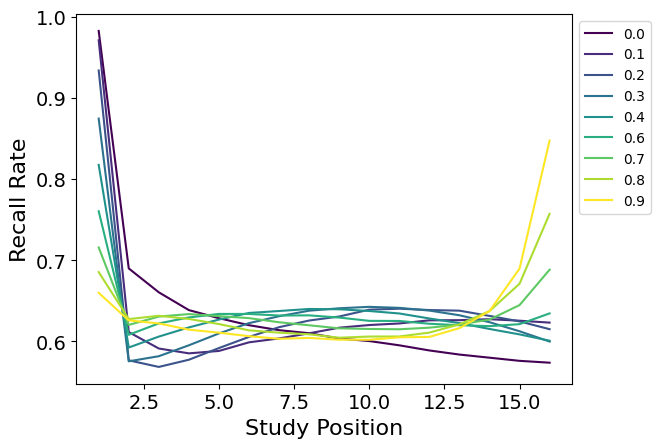

CMR_Encoding_Drift_Rate_Parameter_Shifting_pnr_HealeyKahana2014.png


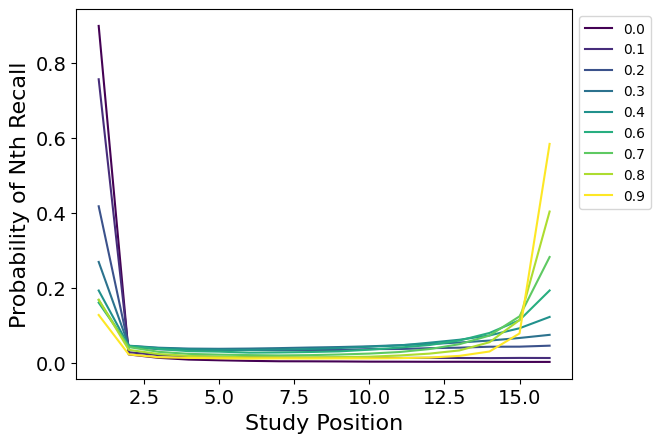

CMR_Start_Drift_Rate_Parameter_Shifting_spc_HealeyKahana2014.png


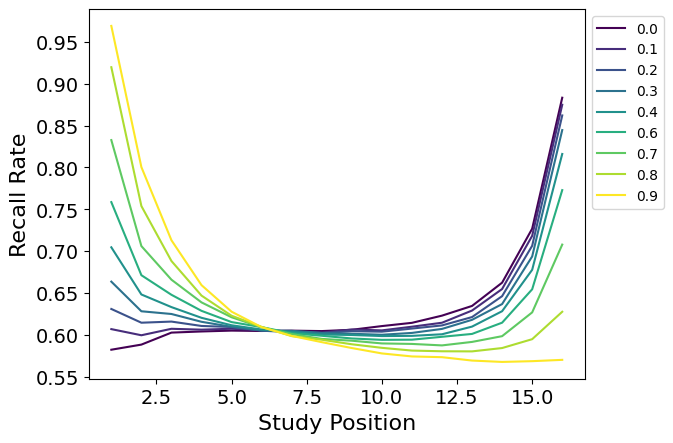

CMR_Start_Drift_Rate_Parameter_Shifting_pnr_HealeyKahana2014.png


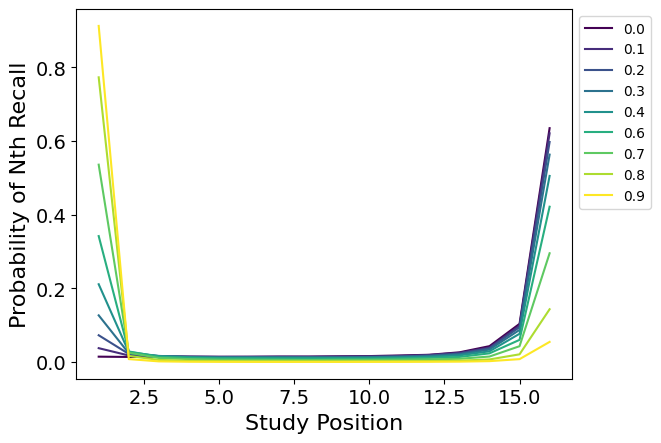

In [ ]:

bounds = {
    "encoding_drift_rate": [2.220446049250313e-16, 0.9999999999999998],
    "start_drift_rate": [2.220446049250313e-16, 0.9999999999999998],
    "recall_drift_rate": [2.220446049250313e-16, 0.9999999999999998],
    "shared_support": [2.220446049250313e-16, 99.9999999999999998],
    "item_support": [2.220446049250313e-16, 9.9999999999999998],
    "learning_rate": [2.220446049250313e-16, 0.9999999999999998],
    "primacy_scale": [2.220446049250313e-16, 99.9999999999999998],
    "primacy_decay": [2.220446049250313e-16, 99.9999999999999998],
    "stop_probability_scale": [2.220446049250313e-16, 0.9999999999999998],
    "stop_probability_growth": [2.220446049250313e-16, 9.9999999999999998],
    "choice_sensitivity": [2.220446049250313e-16, 99.9999999999999998],
    # "encoding_drift_decrease": [2.220446049250313e-16, 0.9999999999999998],
}

rng = random.PRNGKey(0)

for shifted_parameter, (min_value, max_value) in bounds.items():

    color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]
    considered_values = jnp.linspace(start=min_value, stop=max_value, num=len(color_cycle))[:-1]
    rng, rng_iter = random.split(rng)
    sim = parameter_shifted_simulate_h5_from_h5(
        model_factory,
        data,
        connections,
        {key: jnp.array(val) for key, val in fit_result["fits"].items()},
        trial_mask,
        experiment_count,
        shifted_parameter,
        considered_values,
        rng_iter,
    )
    sim = [
        to_numba_typed_dict({key: np.array(val) for key, val in each.items()})
        for each in sim
    ]


    for analysis in analyses:
        figure_str = f"{model_name}_{shifted_parameter.title()}_{run_tag}_{analysis.__name__[5:]}_{data_name}.png"
        print(figure_str)
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]
        cmap = plt.get_cmap('viridis')
        color_cycle = [cmap(i) for i in np.linspace(0, 1, len(considered_values))]
        color_cycle = [mcolors.rgb2hex(c) for c in color_cycle]
        _trial_mask = generate_trial_mask(sim[0], data_query)
        for i in range(len(sim)):
            sim[i]["subject"] *= 0

        axis = analysis(
            datasets=sim,
            trial_masks=[_trial_mask] * len(considered_values),
            color_cycle=color_cycle,
            distances=1 - connections,
            axis=plt.gca(),
            labels=format_floats(considered_values, 1),
            contrast_name=shifted_parameter,
            # handle_repetitions=handle_repetitions[i],

        )

        axis.tick_params(labelsize=14)
        axis.set_xlabel(axis.get_xlabel(), fontsize=16)
        axis.set_ylabel(axis.get_ylabel(), fontsize=16)
        axis.legend(loc="upper left", bbox_to_anchor=(1, 1))
        # axis.set_title(
        #     f"{data_name}_{model_name}_{shifted_parameter.title()}".replace("_", " ")
        # )
        # axis.set_title(shifted_parameter.replace("_", " ").title())

        # plt.savefig(f"{target_directory}{figure_str}", bbox_inches="tight", dpi=600)
        plt.show()
